# Notebook Análisis de Datos 
Maestría Daniel - Marzo 2022

In [1]:
import pandas as pd
import easygui
import numpy as np
import glob
import os
import math
import matplotlib.pyplot as plt

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

#Revisamos que todos los archivos tengan las mismas columnas, cambiamos el nombre de aquellos que no lo tienen
def revisa_columnas():
    path = easygui.fileopenbox()
    data_initial = pd.read_excel(path, index_col=None)  
    variables_initial = data_initial.columns
    
    extension = "xls"
    files = glob.glob('*.{}'.format(extension))
    df = pd.DataFrame()
    i = 0
    diferent_files = 0
    for f in files:
        data = pd.read_excel(f, index_col=None)  
        variables = data.columns
        if variables_initial.equals(variables) == False:
            diferent_files = diferent_files + 1
            old_name = f
            new_name = "+" + f
            os.rename(old_name, new_name)
            print(f, " has been changed to ", new_name)
        i = i + 1
    print("done! There were ", diferent_files, "diferent files! From a total ", i, "files.")

#Funcion para quitar los + al inicio de los nombres
def revierte_nombre():
    extension = "xls"
    files = glob.glob('*.{}'.format(extension))
    changed_names = 0
    for f in files:
        if f.startswith("+"):
            old_name = f
            new_name = old_name[1:]
            os.rename(old_name, new_name)
            changed_names = changed_names + 1
    print(changed_names, " names were changed!")

#Pequeña funcion para comparar columnas
def compara_columnas():
    path_1 = easygui.fileopenbox()
    df_1 = pd.read_excel(path_1, index_col=None)  
    path_2 = easygui.fileopenbox()
    df_2 = pd.read_excel(path_2, index_col=None) 

    print(df_1.columns)
    print(df_2.columns)

def plot_rutas():
    routes_path = r'C:\Users\escob\Desktop\Rutas'
    files = glob.glob(routes_path + '/*.xlsx')
    
    for f in files:
        ruta = pd.read_excel(f, index_col=None)  
        ax1 = ruta.plot(y=["Pendiente (grados)", "vel max [km/hr]"])
        ax1.grid(True, which='both')
        ax1.set_title(f)
        ax1.legend(['Slope (Degrees)', 'Max Vel [km/hr]'])
    #    ax2 = ax1.twinx()
    #    ax2.spines['right'].set_position(('axes', 1.0))
    #    try:
    #        ruta.plot(y=["Longitud final"], ax=ax2, cmap = "tab10", linestyle='dashed')
    #    except: 
    #        ruta.plot(y=["Longitud Final subtramo"], ax=ax2)

def filtro_torque(frame):
    for column in frame:
        if column == "TORQUE TORQUIMETRO MOTOR [Nm]" or column == "TORQUE 2DO TORQUIMETRO [Nm]":
            #print(column)
            frame.loc[:,column].where(frame.loc[:,column] <= 130, 0, inplace=True)

def filtro_rpm(frame):
    for column in frame:
        if column == "RPM TORQUIMETRO MOTOR" or column == "RPM 2DO TORQUIMETRO":
            #print(column)
            frame.loc[:,column].where(frame.loc[:,column] <= 7500, 0, inplace=True)

def future_rolling_average(frame, window = 100):
    filtered_data = frame.copy()
    print("Filtering for a window of size: ", window)
    i = 0
    for i in range(frame.shape[0]):
        if i < (window/2):
            for j in range(frame.shape[1]):
                filtered_data.iloc[i, j] = np.mean(frame.iloc[i:i+int(window/2),j])
        elif i + (window/2) >= frame.shape[0]:
            for j in range(frame.shape[1]):
                filtered_data.iloc[i, j] = np.mean(frame.iloc[i-int(window/2):i,j])
        else:
            for j in range(frame.shape[1]):
                filtered_data.iloc[i, j] = np.mean(frame.iloc[i-int(window/2):i+int(window/2),j])
    return filtered_data

def plot_prueba(data, ini = 0, fin = 0, mode = 0, h_size = 15, v_size = 5, label_w = 1.2, label_h = 1.0, spacing = 0.15):
    if (fin  == 0):
        fin = data.shape[0]

    frame = data.iloc[ini:fin]
    if mode == 0:
        ax1 = frame.plot(y=["RPM TORQUIMETRO MOTOR", "RPM 2DO TORQUIMETRO"], figsize=(h_size,v_size), cmap = "Set1")
        ax1.legend(loc='upper center', bbox_to_anchor=(label_w, label_h), ncol=1, fancybox=True, shadow=True)
        ax1.grid(True, which='both')
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        frame.plot(y=["TORQUE TORQUIMETRO MOTOR [Nm]", "TORQUE 2DO TORQUIMETRO [Nm]"], ax=ax2, figsize=(h_size,v_size), cmap = "tab10", linestyle='dashed')
        ax2.legend(loc='upper center', bbox_to_anchor=(label_w, label_h + spacing), ncol=1, fancybox=True, shadow=True)
        ax3 = ax1.twinx()
        frame.plot(y=["RELATION_T1"], ax=ax3, figsize=(h_size,v_size), cmap = "Set3", linestyle='dotted')
        ax3.legend(loc='upper center', bbox_to_anchor=(label_w, label_h + 2*spacing), ncol=1, fancybox=True, shadow=True)
        ax3.get_yaxis().set_visible(False)
        align_yaxis(ax1, 0, ax2, 0)

    if mode == 1:
        ax1 = frame.plot(y=["RPM TORQUIMETRO MOTOR", "RPM 2DO TORQUIMETRO"], figsize=(h_size,v_size), cmap = "Set1")
        ax1.legend(loc='upper center', bbox_to_anchor=(label_w, label_h), ncol=1, fancybox=True, shadow=True)
        ax1.grid(True, which='both')
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        frame.plot(y=["TORQUE TORQUIMETRO MOTOR [Nm]", "TORQUE 2DO TORQUIMETRO [Nm]"], ax=ax2, figsize=(h_size,v_size), cmap = "tab10", linestyle='dotted')
        ax2.legend(loc='upper center', bbox_to_anchor=(label_w, label_h + spacing), ncol=1, fancybox=True, shadow=True)
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('axes', 1.1))
        frame.plot(y=["ELECTRIC_POWER (W)", "MECHANICAL_POWER (W)"], ax=ax3, figsize=(h_size,v_size), cmap = "Set2", linestyle='dashed')
        ax3.legend(loc='upper center', bbox_to_anchor=(label_w, label_h + 2*spacing), ncol=1, fancybox=True, shadow=True)
        align_yaxis(ax1, 0, ax2, 0)

    if mode == 2:
        ax1 = frame.plot(y=["ELECTRIC_POWER (W)", "MOTOR_POWER (W)", "MECHANICAL_POWER (W)"], figsize=(h_size,v_size), cmap = "Set1")
        ax1.legend(loc='upper center', bbox_to_anchor=(label_w, label_h), ncol=1, fancybox=True, shadow=True)
        ax1.grid(True, which='both')
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        frame.plot(y=["ELECTRIC_EFFICIENCY", "MECHANICAL_EFFICIENCY"], ax=ax2, figsize=(h_size,v_size), cmap = "tab10", linestyle='dashed')
        ax2.legend(loc='upper center', bbox_to_anchor=(label_w, label_h + spacing), ncol=1, fancybox=True, shadow=True)
        align_yaxis(ax1, 0, ax2, 0)

    if mode == 3:
        ax1 = frame.plot(y=["INERTIA_TORQUE (Nm)", "AERO_TORQUE (Nm)", "ROLLING_APPLIED (Nm)", "SLOPE_TORQUE (Nm)"], figsize=(h_size,v_size), cmap = "Set1", linestyle='dashed')
        frame.plot(y=["TORQUE T2 WHEEL (Nm)", "TORQUE SUM AT WHEEL (Nm)"], ax=ax1, figsize=(h_size,v_size), cmap = "tab10")
        ax1.legend(loc='upper center', bbox_to_anchor=(label_w, label_h), ncol=1, fancybox=True, shadow=True)
        ax1.grid(True, which='both')
        #align_yaxis(ax1, 0, ax2, 0)
        
def plot_tramo(data, ini, fin):
    frame = data.iloc[ini:fin]
    ax1 = frame.plot(y=["RPM TORQUIMETRO MOTOR", "RPM 2DO TORQUIMETRO"], figsize=(10,5), cmap = "Set1")
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    frame.plot(y=["TORQUE TORQUIMETRO MOTOR [Nm]", "TORQUE 2DO TORQUIMETRO [Nm]"], ax=ax2, figsize=(10,5), cmap = "tab10")

def carga_prueba():
    path = easygui.fileopenbox()
    frame = pd.read_excel(path, index_col=None)  
    print(path, " loaded")
    path = r'Eff_motor.xlsx'
    eff = pd.read_excel(path, index_col=None, header=None)
    return frame, eff

def get_energia_electrica(frame, eff_array):
    index_torque  = np.floor(frame["TORQUE TORQUIMETRO MOTOR [Nm]"] / 5)
    index_rpm = np.floor(frame["RPM TORQUIMETRO MOTOR"] / 250)
    frame["MOTOR_POWER (W)"] = frame["RPM TORQUIMETRO MOTOR"] * frame["TORQUE TORQUIMETRO MOTOR [Nm]"]
    frame["ELECTRIC_EFFICIENCY"] = frame["MOTOR_POWER (W)"]
    for i in range(frame.shape[0]):
        frame.loc[i,"ELECTRIC_EFFICIENCY"] = eff_array.iloc[int(index_torque[i]), int(index_rpm[i])]
    frame["ELECTRIC_POWER (W)"] = frame["MOTOR_POWER (W)"] / (frame["ELECTRIC_EFFICIENCY"] + 0.00001)

def get_energia_dina(frame, m_eff = 0.95):
   frame["MECHANICAL_POWER (W)"] = frame["RPM 2DO TORQUIMETRO"] * frame["TORQUE 2DO TORQUIMETRO [Nm]"] * m_eff
   frame["MECHANICAL_EFFICIENCY"] = frame["MECHANICAL_POWER (W)"] / (frame["MOTOR_POWER (W)"] + 0.00001)
   frame.loc[:,"MECHANICAL_EFFICIENCY"].where(frame.loc[:,"MECHANICAL_EFFICIENCY"] <= 3, 0, inplace=True)

def get_torque_inercia(frame, mass, dt = 0.5, r_wheel = 0.38):
    for i in range(frame.shape[0]):
        if i == 0:
            frame.loc[i,"INERTIA_TORQUE (Nm)"] = ((((frame.loc[i,"VELOCIDAD EN (Km/h)"] - frame.loc[i,"VELOCIDAD EN (Km/h)"]) * 0.2777777) * mass) / dt) * r_wheel
        if i > 0:
            frame.loc[i,"INERTIA_TORQUE (Nm)"] = ((((frame.loc[i,"VELOCIDAD EN (Km/h)"] - frame.loc[i - 1,"VELOCIDAD EN (Km/h)"]) * 0.2777777) * mass) / dt) * r_wheel

def get_torque_aero(frame, bus_front = "squared", width = 2.3, height = 2.7, r_wheel = 0.38):
    densidad = 1.225
    if bus_front == "squared":
        drag = 1.15
    coefficient = (width*height) * drag * densidad
    for i in range(frame.shape[0]):
        frame.loc[i,"AERO_TORQUE (Nm)"] = 0.5 * ((0.277777777 * frame.loc[i,"VELOCIDAD EN (Km/h)"]) ** 2) * coefficient * r_wheel

def get_torque_rolling(frame, mass, r_static = 0.1, r_dinamic = 0.1, r_wheel = 0.38, rolling_coef = 1.0):
    max_rpm = 7000
    rolling = np.array([1.5,2.5,2.7,2.8,3,3.2,3.4,3.6,3.8,4,4.3,4.6,5,6,7,8])
    static_rolling = 9.8 * mass * r_static
    for i in range(frame.shape[0]):
        vel_ms = 0.277777777 * frame.loc[i,"VELOCIDAD EN (Km/h)"]
        frame.loc[i,"ROLLING_BUS (Nm)"] = ((vel_ms) * r_dinamic + static_rolling) * r_wheel
        index = np.round((frame.loc[i,"RPM TORQUIMETRO MOTOR"]/max_rpm) * len(rolling))
        if index == 16:
            index = 15
        frame.loc[i,"ROLLING_DINA (Nm)"] = frame.loc[i,"RELATION_T1"] * rolling[int(index)]
    #frame["ROLLING_APPLIED (Nm)"] = frame["ROLLING_BUS (Nm)"] - frame["ROLLING_DINA (Nm)"]
    frame["ROLLING_APPLIED (Nm)"] = rolling_coef * frame["ROLLING_DINA (Nm)"]

def get_torque_slope(frame, mass, ruta, mode = 'true', r_wheel = 0.38):
    if mode == 'true':
        for i in range(frame.shape[0]):
            #try:
                for j in range(ruta.shape[0]):
                    if ruta.loc[j, "N° tramo.1"] == frame.loc[i, "NUMERO DE TRAMO"]:
                        frame.loc[i,"SLOPE"] = ruta.loc[j, "Pendiente (grados)"]
                        break
            #except:
                #frame.loc[i,"SLOPE"] = 0
    frame.loc[:,"SLOPE_TORQUE (Nm)"] = 9.81 * mass * np.sin(frame.loc[:,"SLOPE"] * 0.0174533) * r_wheel #9.81 * mass * np.sin(frame.loc[:,"SLOPE"])

def torque_at_wheel(frame):
    frame["TORQUE T1 WHEEL (Nm)"] = frame["TORQUE TORQUIMETRO MOTOR [Nm]"] * frame["RELATION_T1"]
    frame["TORQUE T2 WHEEL (Nm)"] = frame["TORQUE TORQUIMETRO MOTOR [Nm]"] * frame["RELATION_T2"]
    frame["TORQUE SUM AT WHEEL (Nm)"] = frame["ROLLING_APPLIED (Nm)"] + frame["INERTIA_TORQUE (Nm)"] + frame["AERO_TORQUE (Nm)"] + frame["SLOPE_TORQUE (Nm)"]

def procesa_datos(frame, motor_efficiency, window = 15):
    #Filtros
    filtro_rpm(frame)
    print("RPM FILTERED!")
    filtro_torque(frame)
    print("TORQUE FILTERED!")
    frame_f = future_rolling_average(frame, window)
    frame_f["NUMERO DE TRAMO"] = frame["NUMERO DE TRAMO"]
    print("NEW SOFTENED DF CREATED")
    #Corrección de torque
    frame.loc[:,"TORQUE TORQUIMETRO MOTOR [Nm]"] = frame.loc[:,"TORQUE TORQUIMETRO MOTOR [Nm]"] + 2
    frame_f.loc[:,"TORQUE TORQUIMETRO MOTOR [Nm]"] = frame_f.loc[:,"TORQUE TORQUIMETRO MOTOR [Nm]"] + 2
    #Electric Energy
    get_energia_electrica(frame, motor_efficiency)
    get_energia_electrica(frame_f, motor_efficiency)
    print("ELECTRIC ENERGY ADDED")
    #Mechanical Energy
    get_energia_dina(frame)
    get_energia_dina(frame_f)
    print("MECHANICAL ENERGY ADDED")
    #CALCULATE TORQUES!!!
    get_torque_inercia(frame, masa)
    get_torque_inercia(frame_f, masa)
    print("INERTIA TORQUE ADDED")
    get_torque_aero(frame)
    get_torque_aero(frame_f)
    print("AERO TORQUE ADDED")
    get_torque_rolling(frame, masa)
    get_torque_rolling(frame_f, masa)
    print("ROLLING TORQUE ADDED")
    get_torque_slope(frame, masa, ruta)
    get_torque_slope(frame_f, masa, ruta)
    print("SLOPE TORQUE ADDED")

    #Prepare Variables for Energy Segregation
    torque_at_wheel(frame)
    torque_at_wheel(frame_f)
    
    #Reorder Variables
    frame = frame.loc[:,["RPM TORQUIMETRO MOTOR", "TORQUE TORQUIMETRO MOTOR [Nm]", "RPM 2DO TORQUIMETRO", "TORQUE 2DO TORQUIMETRO [Nm]", "VELOCIDAD EN (Km/h)", "DISTANCIA TOTAL ACUMULADA REAL [m]", "RELATION_T1", "RELATION_T2", "TORQUE T1 WHEEL (Nm)", "TORQUE T2 WHEEL (Nm)", "ELECTRIC_POWER (W)", "MOTOR_POWER (W)", "MECHANICAL_POWER (W)", "ELECTRIC_EFFICIENCY", "MECHANICAL_EFFICIENCY", "INERTIA_TORQUE (Nm)", "AERO_TORQUE (Nm)", "SLOPE_TORQUE (Nm)", "ROLLING_APPLIED (Nm)", "TORQUE SUM AT WHEEL (Nm)", "SLOPE", "NUMERO DE TRAMO"]]
    frame_f = frame_f.loc[:,["RPM TORQUIMETRO MOTOR", "TORQUE TORQUIMETRO MOTOR [Nm]", "RPM 2DO TORQUIMETRO", "TORQUE 2DO TORQUIMETRO [Nm]", "VELOCIDAD EN (Km/h)", "DISTANCIA TOTAL ACUMULADA REAL [m]", "RELATION_T1", "RELATION_T2", "TORQUE T1 WHEEL (Nm)", "TORQUE T2 WHEEL (Nm)", "ELECTRIC_POWER (W)", "MOTOR_POWER (W)", "MECHANICAL_POWER (W)", "ELECTRIC_EFFICIENCY", "MECHANICAL_EFFICIENCY", "INERTIA_TORQUE (Nm)", "AERO_TORQUE (Nm)", "SLOPE_TORQUE (Nm)", "ROLLING_APPLIED (Nm)", "TORQUE SUM AT WHEEL (Nm)", "SLOPE", "NUMERO DE TRAMO"]]

    print("PROCESSING DONE, RETURNING NEW DF")
    return frame_f

In [3]:
df, eff = carga_prueba()

C:\Users\escob\Desktop\Reportes\Pruebas160755_20-12-07.xls  loaded


In [4]:
masa = df["MASA [Kg]"].iloc[int(np.round(df.shape[0]/2))]
data = df.loc[:,["RPM TORQUIMETRO MOTOR", "TORQUE TORQUIMETRO MOTOR [Nm]", "RPM 2DO TORQUIMETRO", "TORQUE 2DO TORQUIMETRO [Nm]", "VELOCIDAD EN (Km/h)", "DISTANCIA TOTAL ACUMULADA REAL [m]", "NUMERO DE TRAMO"]]
data["RELATION_T1"] = ((data["RPM TORQUIMETRO MOTOR"]/30)*np.pi) / ((data["VELOCIDAD EN (Km/h)"]+0.0001) / (3.6 * 0.38))
data["RELATION_T2"] = ((data["RPM 2DO TORQUIMETRO"]/30)*np.pi) / ((data["VELOCIDAD EN (Km/h)"]+0.0001) / (3.6 * 0.38))

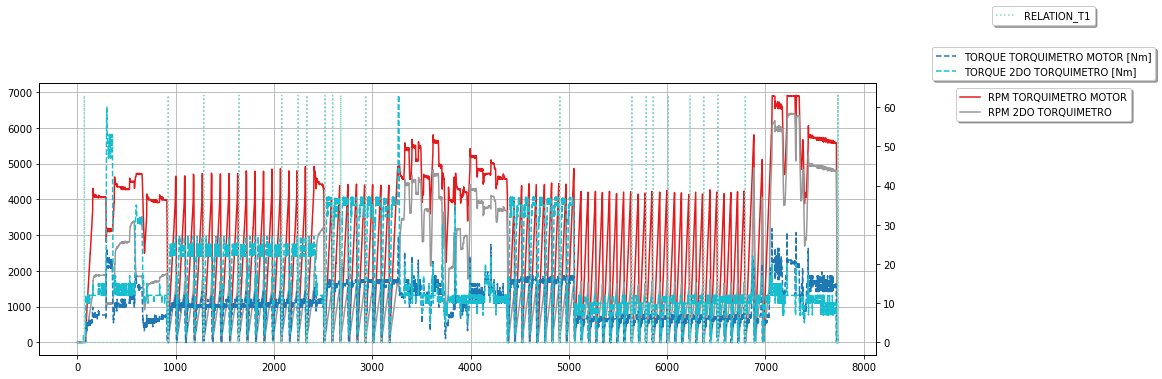

In [5]:
filtro_rpm(data)
filtro_torque(data)
plot_prueba(data)

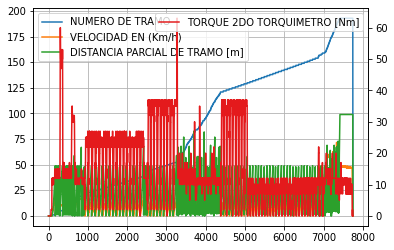

In [6]:
ax = df.plot(y=["NUMERO DE TRAMO", "VELOCIDAD EN (Km/h)", "DISTANCIA PARCIAL DE TRAMO [m]"])
ax2 = ax.twinx()
df.plot(y=["TORQUE 2DO TORQUIMETRO [Nm]"], ax = ax2, cmap = "Set1")
ax.grid(True, which='both')

In [7]:
path = easygui.fileopenbox()
ruta = pd.read_excel(path, index_col=None)  
print(path, " loaded")

C:\Users\escob\Desktop\Rutas\Ruta 283.xlsx  loaded


In [8]:
data_f = procesa_datos(data, eff, window = 15)

RPM FILTERED!
TORQUE FILTERED!
Filtering for a window of size:  15
NEW SOFTENED DF CREATED
ELECTRIC ENERGY ADDED
MECHANICAL ENERGY ADDED
INERTIA TORQUE ADDED
AERO TORQUE ADDED
ROLLING TORQUE ADDED
SLOPE TORQUE ADDED
PROCESSING DONE, RETURNING NEW DF


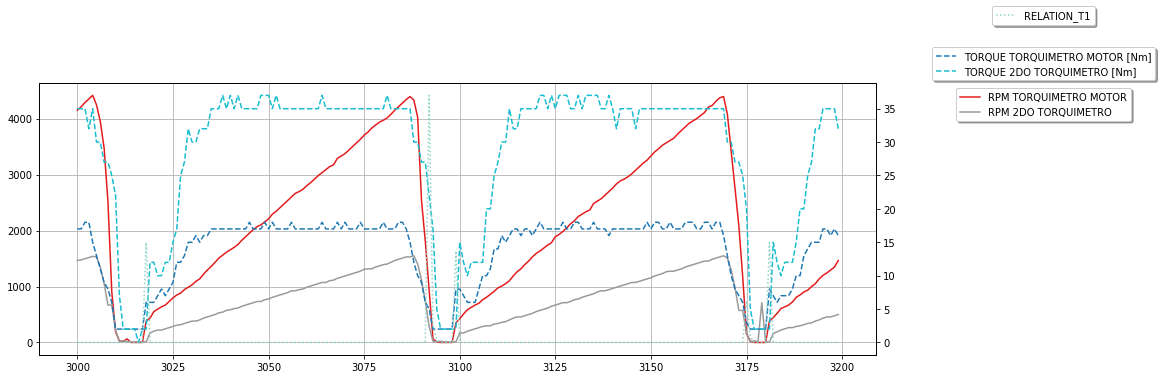

In [9]:
plot_prueba(data, mode = 0, ini=3000, fin = 3200)

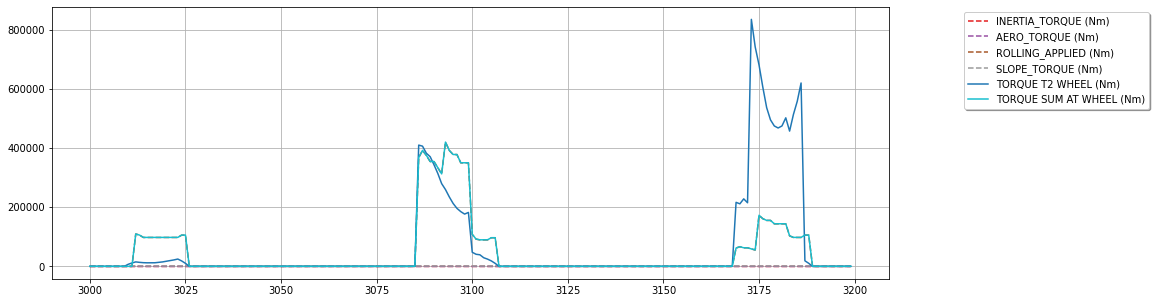

In [10]:
plot_prueba(data_f, mode = 3, ini=3000, fin = 3200)

In [11]:
data["RPM TORQUIMETRO MOTOR"].isna().sum()

0

In [27]:
j = 0
for i in range(data.shape[0]):
    temp = ((data.loc[i, "RPM TORQUIMETRO MOTOR"]/30)*np.pi) / ((data.loc[i,"VELOCIDAD EN (Km/h)"]+0.0001) / (3.6 * 0.38))
    if temp > 1000 or math.isnan(temp):
        j = j+1
        print(i, data.loc[i, "RPM TORQUIMETRO MOTOR"], data.loc[i,"VELOCIDAD EN (Km/h)"], temp)

print(j)

84 286 0.0 409713.94751056645
927 424 0.0 607408.0900156649
1016 339 0.0 485639.9587625246
1197 392 0.0 561565.9700144826
1281 169 0.0 242103.69625624383
1282 10 0.0 14325.662500369455
1283 21 0.0 30083.891250775858
1284 10 0.0 14325.662500369455
1290 361 0.0 517156.41626333736
1552 254 0.0 363871.8275093842
1557 329 0.0 471314.29626215517
1639 722 0.0 1034312.8325266747
1640 31 0.0 44409.553751145315
1641 21 0.0 30083.891250775858
1647 435 0.0 623166.3187660713
1727 807 0.0 1156080.963779815
1728 106 0.0 151852.02250391623
1729 21 0.0 30083.891250775858
1734 371 0.0 531482.0787637068
1821 350 0.0 501398.187512931
1902 212 0.0 303704.04500783246
1907 371 0.0 531482.0787637068
1987 700 0.0 1002796.375025862
1988 297 0.0 425472.17626097286
1989 21 0.0 30083.891250775858
1994 339 0.0 485639.9587625246
2074 966 0.0 1383858.9975356895
2075 84 0.0 120335.56500310343
2081 456 0.0 653250.2100168472
2165 392 0.0 561565.9700144826
2244 84 0.0 120335.56500310343
2250 456 0.0 653250.2100168472
232

<AxesSubplot:>

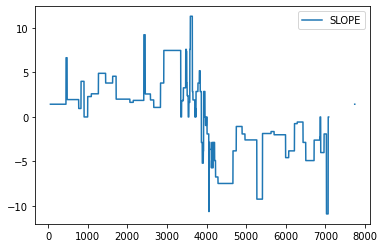

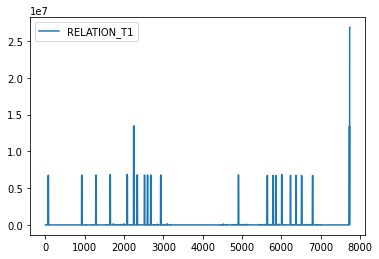

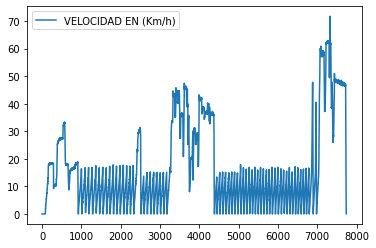

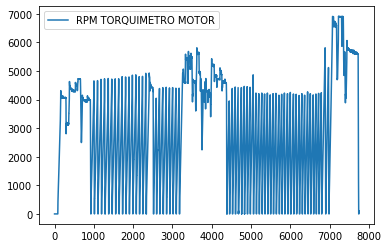

In [13]:
#data_f.plot(y=["SLOPE_TORQUE (Nm)"])
data_f.plot(y=["SLOPE"])
data_f.plot(y=["RELATION_T1"])
data.plot(y=["VELOCIDAD EN (Km/h)"])
data.plot(y=["RPM TORQUIMETRO MOTOR"])